In [1]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

def get_delta_u(directory,inp,flist,y,thresh=0.1,y0=0): #flist is lscales, y0 = [0,1,2]
    mat = np.zeros([len(flist),5])

    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get y lengthscale and corresponding idx
        autocorr = np.fromfile(fname,sep=' ')
        autocorr = np.reshape(autocorr,[Ny,3])
        ly,i1,i2 = get_lscale(y,autocorr[:,y0],thresh=thresh)
        ny = int(Ny*ly/Ly)
        
        # Get corresponding du
        utilde = np.fromfile(directory+'/shearlayer_utilde_%04d.dat'%tID,sep=' ')
        ic = np.argmin(abs(utilde))
        du = abs(utilde[i2]-utilde[i1])
        
        # Get L99
        #L99,itop,ibot = get_L99(-y,utilde)
        
        # Plot to check
        #plt.plot(y,utilde)
        #plt.plot([y[i1],y[i2]],[0,0],'-o')
        #plt.plot([y[itop],y[ibot]],[0,0],'k-o')
        
        mat[i,0] = time
        mat[i,1] = du/inp.du
        mat[i,2] = ly
        mat[i,3] = du/ly # local shear
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

In [3]:
# directory='/lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512/'
directory = '/home/kmatsuno/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
x = np.linspace(0,Lx,Nx)
z = np.linspace(0,Lz,Nz)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

flist = glob.glob(directory+"*lscale_vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])

Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 7.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['lscale_vv_0001.dat', 'lscale_vv_0002.dat', 'lscale_vv_0003.dat', 'lscale_vv_0004.dat', 'lscale_vv_0005.dat', 'lscale_vv_0006.dat', 'lscale_vv_0007.dat', 'lscale_vv_0008.dat', 'lscale_vv_0009.dat', 'lscale_vv_0010.dat', 'lscale_vv_0014.dat', 'lscale_vv_0015.dat', 'lscale_vv_0016.dat', 'lscale_vv_0020.dat', 'lscale_vv_0021.dat', 'lscale_vv_0022.dat', 'lscale_vv_0023.dat', 'lscale_vv_0024.dat', 'lscale_vv_0025.dat', 'lscale_vv_0026.dat', 'lscale_vv_0027.dat', 'lscale_vv_0028.dat', 'lscale_vv_0058.dat', 'lscale_vv_0059.dat', 'lscale_vv_0060.dat', 'lscale_vv_0061.dat', 'lscale_vv_0062.dat', 'lscale_vv_0063.dat', 'lscale_vv_0064.dat', 'lscale_vv_0065.dat', 'lscale_vv_0066.dat', 'lscale_vv_0067.dat', 'lscale_vv_0068.dat', 'lscale_vv_0069.dat', 'lscale_vv_0070.dat', 'lscale_vv_0071.dat', 'lscale_vv_0072.dat', 'lscale_vv_0073.dat', 'lscale_vv_0074.dat', 'lscale_vv_0075.dat', 'l

0.2:[0.487473327013,0.0830669730333],
0.2:[0.263088895996,0.0299309786751],
0.2:[0.526936435487,0.041000994127],


(600, 800)

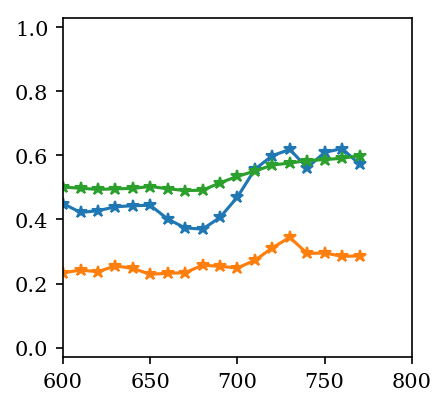

In [21]:

fig = plt.figure(figsize=(3,3),dpi=150)
dat = {}
dat[0] = get_delta_u(directory,inp,flist,y,y0=0)
dat[1] = get_delta_u(directory,inp,flist,y,y0=1)
dat[2] = get_delta_u(directory,inp,flist,y,y0=2)

t = dat[0][:,0]

ist = -20
ie = None
istat = 1 #1: du/dU, 2:ly, 3: du/ly
for i in range(3):
    plt.plot(t,dat[i][:,1],'-*')
    print('{}:[{},{}],'.format(inp.Mc,np.mean(dat[i][ist:ie,istat]),np.std(dat[i][ist:ie,istat])))
plt.xlim([600,800])

0.2:[0.561107531708,0.0570801406206],
0.8:[0.377911355901,0.0392722326874],
2.0:[0.306866737327,0.0618924415449],
Done


Text(0.5,0,'$t/\\Delta U$')

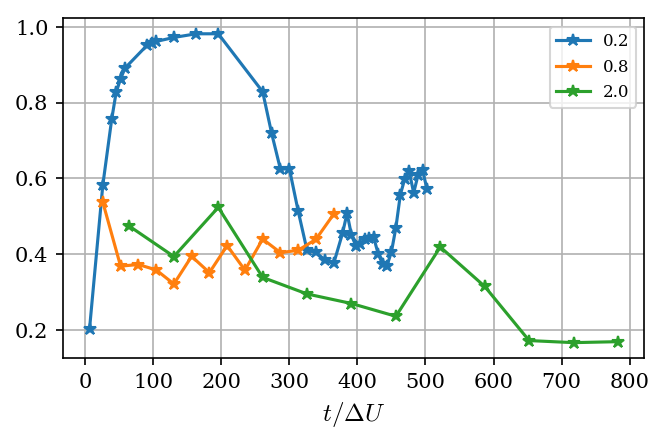

In [7]:
s = '7'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)
ax = plt.axes()

for Mc in Mc_list:
    if s=='1' and (Mc is '04' or Mc is '02'):
        dir_out = '/home/kmatsuno/ShearLayerData/temporal/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    else:
        dir_out = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(dir_out,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(dir_out,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    lscale = 'vv'
    flist = glob.glob(dir_out+"*lscale_%s*"%lscale)
    flist.sort()
    
    # plane 0:yc, 1:yc+L99/4, 2:yc-L99/4
    dat = get_delta_u(dir_out,inp,flist,y,thresh=0.1,y0=0)    
    t = dat[:,0]*inp.du
    f = dat[:,1] # 1:du/inp.du, 2:ly, 3:du/ly (local shear)
    ax.plot(t,f,'-*',label='{}'.format(inp.Mc))
    
    #if Mc=='02': ist=5;ien=10 # mira run
    if Mc=='02': ist=-8;ien=-4 # theta run
    #elif Mc=='04': ist=8;ien=14 #mira run
    elif Mc=='04': ist=5;ien=8 #theta run
    elif Mc=='08': ist=3;ien=-4
    elif Mc=='12': ist=4;ien=None
    elif Mc=='16': ist=4;ien=None
    elif Mc=='20': ist=4;ien=-3
    else: ist=0; ien=None 
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[ist:ien]),np.std(f[ist:ien])))
    
print('Done')
ax.grid(True)
ax.legend()
ax.set_xlabel(r'$t/\Delta U$')

In [4]:
# THRESH = 0.1
du = {# Centered at y0=y_c
0.2:[0.574137882739,0.117924053771],
0.4:[0.516598893174,0.0517583826384],
0.8:[0.34328828939,0.0357882812154],
1.2:[0.288284913923,0.0232571237128],
1.6:[0.284424366299,0.0325989118031],
2.0:[0.245942817302,0.0164289592739],
}
du_top = {# Centered at y0=y_c+L99/4
0.2:[0.556604784141,0.0582789661326],
0.4:[0.494276945032,0.0567590341106],
0.8:[0.349004778461,0.0273828563523],
1.2:[0.303370919252,0.0388738428487],
1.6:[0.234783403587,0.0274336982291],
2.0:[0.199347152045,0.039950013853],
}
du_bot = {# Centered at y0=y_c-L99/4
0.2:[0.56283393864,0.0338065654472],
0.4:[0.510515323745,0.0525758872021],
0.8:[0.354914114663,0.025061128945],
1.2:[0.289664952588,0.0331898920749],
1.6:[0.230950382487,0.0175973516091],
2.0:[0.179530635028,0.0195510886492],
}

In [14]:
# s=7 THRESH = 0.1
du_s7 = {# Centered at y0=y_c
0.2:[0.252239340357,0.0314378986591],
0.8:[0.196498053737,0.0143538269484],
2.0:[0.150669226645,0.0373191933283],
}

In [2]:
# THRESH = 0.2
du = {# Centered at y0=y_c
0.2:[0.394983511722,0.0549826603579],
0.4:[0.327205355933,0.0250326584392],
0.8:[0.210487904818,0.0153380860926],
1.2:[0.184304575761,0.0133835171808],
1.6:[0.176168143662,0.0196856650091],
2.0:[0.161965176887,0.0104328612725],
}
du_s7 = {
0.2:[0.212809887078,0.0174258713457],
0.8:[0.191486082107,0.0119116965823],
2.0:[0.137051163804,0.0110047225507],
}
du_top = {# Centered at y0=y_c+L99/4
0.2:[0.348351803439,0.0321863062538],
0.4:[0.318349855016,0.0402264852498],
0.8:[0.216280255935,0.0157901698811],
1.2:[0.178516267348,0.01343070115],
1.6:[0.143200000102,0.00947425502836],
2.0:[0.119503000752,0.0131096338295],
}
du_bot = {# Centered at y0=y_c-L99/4
0.2:[0.381889170741,0.0354389421975],
0.4:[0.343369343797,0.0437451043116],
0.8:[0.226358767152,0.0196100035464],
1.2:[0.173361976781,0.0159602806801],
1.6:[0.142335180512,0.0107515906314],
2.0:[0.114876443661,0.00643898652214],
}

Text(0.2,0.17,'(b)')

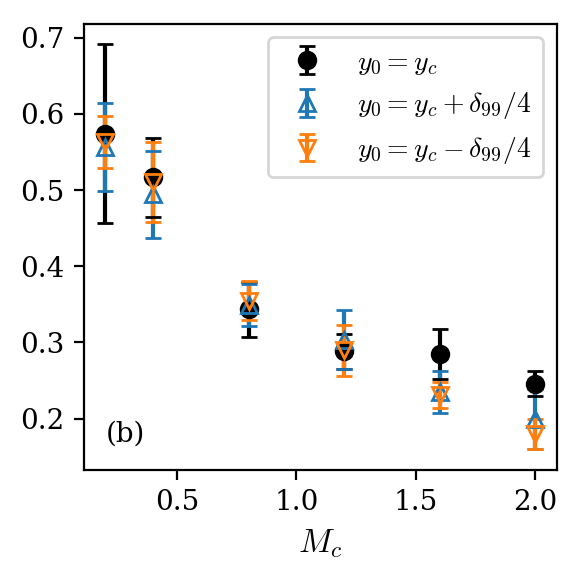

In [5]:
def plotter(dat,label,fmt,fillstyle='full'):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],
                 fillstyle=fillstyle, fmt=fmt,label=label,capsize=3)
    
fig = plt.figure(figsize=(3,3),dpi=200)
plotter(du,r'$y_0=y_c$','ko')
plotter(du_top,r'$y_0=y_c+\delta_{99}/4$','^',fillstyle='none')
plotter(du_bot,r'$y_0=y_c-\delta_{99}/4$','v',fillstyle='none')

# plt.grid(True)
plt.xlabel(r'$M_c$')
# plt.ylabel(r'$U_\delta/\Delta \bar{u}$')
# plt.ylim([0.05,0.4])
plt.tight_layout()
plt.legend(fontsize=10)
plt.annotate('(b)',(0.2,0.17),fontsize=10)

In [9]:
cases = { 
0.2:'A1',
0.4:'B1',
0.8:'C1',
1.2:'D1',
1.6:'E1',
2.0:'F1',}

for key in sorted(du.keys()):
    print('{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\'.format(
        key,ly_L99[key][0],lx_L99[key][0],lx_ly[key][0],lz_ly[key][0],du[key][0]))

0.2 & 0.29 & 0.52 & 1.76 & 1.22 & 0.32 \\
0.4 & 0.24 & 0.45 & 1.92 & 1.24 & 0.29 \\
0.8 & 0.15 & 0.27 & 1.76 & 1.09 & 0.18 \\
1.2 & 0.13 & 0.23 & 1.81 & 1.09 & 0.15 \\
1.6 & 0.12 & 0.20 & 1.73 & 1.12 & 0.14 \\
2.0 & 0.10 & 0.18 & 1.78 & 1.07 & 0.14 \\
